**SetUp**

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir(r'/content/drive/My Drive/MAIS/Final Project')

In [0]:
!cp kaggle.json /root/.kaggle/

In [18]:
!pip install --upgrade pip

     |████████████████████████████████| 1.4MB 2.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [19]:
!pip uninstall kaggle

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Would remove:
    /usr/local/bin/kaggle
    /usr/local/lib/python3.6/dist-packages/kaggle-1.5.6.dist-info/*
    /usr/local/lib/python3.6/dist-packages/kaggle/*
Proceed (y/n)? y
  Successfully uninstalled kaggle-1.5.6


In [20]:
!pip install kaggle==1.5.6

     |████████████████████████████████| 58 kB 1.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=2e0fb811357726915c938f717c53b7ad369c472a2056794047f5eaf120e7ef34
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [22]:
#upload dataset to drive directory
!kaggle competitions download -c job-recommendation

 99% 1.38G/1.39G [00:11<00:00, 141MB/s]
100% 1.39G/1.39G [00:11<00:00, 132MB/s]


**Load Data**

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [29]:
!unzip -o 'input_data/jobs.zip' -d input_data/

Archive:  input_data/jobs.zip
  inflating: input_data/jobs.tsv     


In [30]:
!ls ./input_data/*.tsv

./input_data/apps.tsv	     ./input_data/user_history.tsv
./input_data/jobs.tsv	     ./input_data/users.tsv
./input_data/test_users.tsv  ./input_data/window_dates.tsv


In [31]:
apps = pd.read_csv('./input_data/apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv('./input_data/user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv('./input_data/jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
users = pd.read_csv('./input_data/users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv('./input_data/test_users.tsv', delimiter='\t',encoding='utf-8')

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'


In [34]:
apps.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [35]:
apps.columns

Index(['UserID', 'WindowID', 'Split', 'ApplicationDate', 'JobID'], dtype='object')

In [36]:
apps.shape

(1603111, 5)

In [37]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603111 entries, 0 to 1603110
Data columns (total 5 columns):
UserID             1603111 non-null int64
WindowID           1603111 non-null int64
Split              1603111 non-null object
ApplicationDate    1603111 non-null object
JobID              1603111 non-null int64
dtypes: int64(3), object(2)
memory usage: 61.2+ MB


In [38]:
user_history.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [39]:
user_history.columns

Index(['UserID', 'WindowID', 'Split', 'Sequence', 'JobTitle'], dtype='object')

In [40]:
user_history.shape

(1753901, 5)

In [41]:
user_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753901 entries, 0 to 1753900
Data columns (total 5 columns):
UserID      int64
WindowID    int64
Split       object
Sequence    int64
JobTitle    object
dtypes: int64(3), object(2)
memory usage: 66.9+ MB


In [42]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [43]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [44]:
jobs.shape

(1091923, 11)

In [45]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
JobID           1091923 non-null int64
WindowID        1091923 non-null int64
Title           1091916 non-null object
Description     1091913 non-null object
Requirements    1050521 non-null object
City            1091921 non-null object
State           1091922 non-null object
Country         1091920 non-null object
Zip5            685724 non-null object
StartDate       1091923 non-null object
EndDate         1091914 non-null object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


In [47]:
users.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [48]:
users.columns

Index(['UserID', 'WindowID', 'Split', 'City', 'State', 'Country', 'ZipCode',
       'DegreeType', 'Major', 'GraduationDate', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany'],
      dtype='object')

In [49]:
users.shape

(389708, 15)

In [51]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389708 entries, 0 to 389707
Data columns (total 15 columns):
UserID                  389708 non-null int64
WindowID                389708 non-null int64
Split                   389708 non-null object
City                    389708 non-null object
State                   389218 non-null object
Country                 389708 non-null object
ZipCode                 387974 non-null object
DegreeType              389708 non-null object
Major                   292468 non-null object
GraduationDate          269477 non-null object
WorkHistoryCount        389708 non-null int64
TotalYearsExperience    375528 non-null float64
CurrentlyEmployed       347632 non-null object
ManagedOthers           389708 non-null object
ManagedHowMany          389708 non-null int64
dtypes: float64(1), int64(4), object(10)
memory usage: 44.6+ MB


In [52]:
test_users.head()

,UserID,WindowID
0,767,1
1,769,1
2,861,1
3,1006,1
4,1192,1


In [53]:
test_users.columns

Index(['UserID', 'WindowID'], dtype='object')

In [54]:
test_users.shape

(22838, 2)

In [55]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 2 columns):
UserID      22838 non-null int64
WindowID    22838 non-null int64
dtypes: int64(2)
memory usage: 357.0 KB


**EDA and Preprocessing**

In [0]:
apps_training = apps.loc[apps['Split'] == 'Train']

In [57]:
apps_training.shape

(1417514, 5)

In [58]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [0]:
apps_testing = apps.loc[apps['Split'] == 'Test']

In [60]:
apps_testing.shape

(185597, 5)

In [61]:
apps_testing.head()

,UserID,WindowID,Split,ApplicationDate,JobID
126,767,1,Test,2012-04-01 14:37:20.023,85377
127,769,1,Test,2012-04-16 22:36:52.48,853328
128,769,1,Test,2012-04-09 18:59:28.193,86106
129,769,1,Test,2012-04-09 18:59:31.127,327571
130,769,1,Test,2012-04-08 21:29:11.993,119161


In [0]:
user_history_training = user_history.loc[user_history['Split'] =='Train']

In [0]:
user_history_training = user_history.loc[user_history['Split'] =='Train']
user_history_testing = user_history.loc[user_history['Split'] =='Test']
apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']
users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

In [68]:
user_history_training.shape

(1652513, 5)

In [69]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [0]:
user_history_testing = user_history.loc[user_history['Split'] =='Test']

In [71]:
user_history_testing.shape

(101388, 5)

In [72]:
user_history_testing.head()

,UserID,WindowID,Split,Sequence,JobTitle
144,767,1,Test,1,Claims Adjuster
145,767,1,Test,2,Professional Baseball Player
146,767,1,Test,3,Professional Baseball Player
147,767,1,Test,4,Professional Baseball Player
148,767,1,Test,5,Professional Baseball Player


In [0]:
users_training = users.loc[users['Split']=='Train']

In [74]:
users_training.shape

(366870, 15)

In [75]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [0]:
users_testing = users.loc[users['Split']=='Test']

In [77]:
users_testing.shape

(22838, 15)

In [78]:
users_testing.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
31,767,1,Test,Murrieta,CA,US,92562,Bachelor's,University Studies/Business,2008-05-01 00:00:00,5,16.0,No,No,0
32,769,1,Test,Roselle,IL,US,60172,Bachelor's,Radio-Television,2011-05-01 00:00:00,5,5.0,Yes,No,0
33,861,1,Test,Morris,IL,US,60450,High School,General Studies,1989-05-01 00:00:00,7,21.0,NaN,No,0
38,1006,1,Test,West Chester,PA,US,19382,High School,Not Applicable,2008-06-01 00:00:00,3,6.0,Yes,No,0
44,1192,1,Test,Cincinnati,OH,US,45255,Bachelor's,Marketing,NaN,5,6.0,Yes,No,0


**Records**

In [79]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [80]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [81]:
users_training.head(5).transpose()

,0,1,2,3,4
UserID,47,72,80,98,123
WindowID,1,1,1,1,1
Split,Train,Train,Train,Train,Train
City,Paramount,La Mesa,Williamstown,Astoria,Baton Rouge
State,CA,CA,NJ,NY,LA
Country,US,US,US,US,US
ZipCode,90723,91941,08094,11105,70808
DegreeType,High School,Master's,High School,Master's,Bachelor's
Major,NaN,Anthropology,Not Applicable,Journalism,Agricultural Business
GraduationDate,1999-06-01 00:00:00,2011-01-01 00:00:00,1985-06-01 00:00:00,2007-05-01 00:00:00,2011-05-01 00:00:00


In [82]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [83]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

,City,State,Country,Locationwise
0,&#60;&#47;b&#62; Brno &#60;b&#62;,,CZ,1
1,&#60;&#47;b&#62; Praha &#60;b&#62;,,CZ,1
2,- Any,,CZ,13
3,29 Palms,CA,US,1
4,<,,HU,1
...,...,...,...,...
15689,puebla,,MX,1
15690,san jose,,BJ,6
15691,san jose,,UA,1
15692,seoul,,KR,2


In [84]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [0]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False)

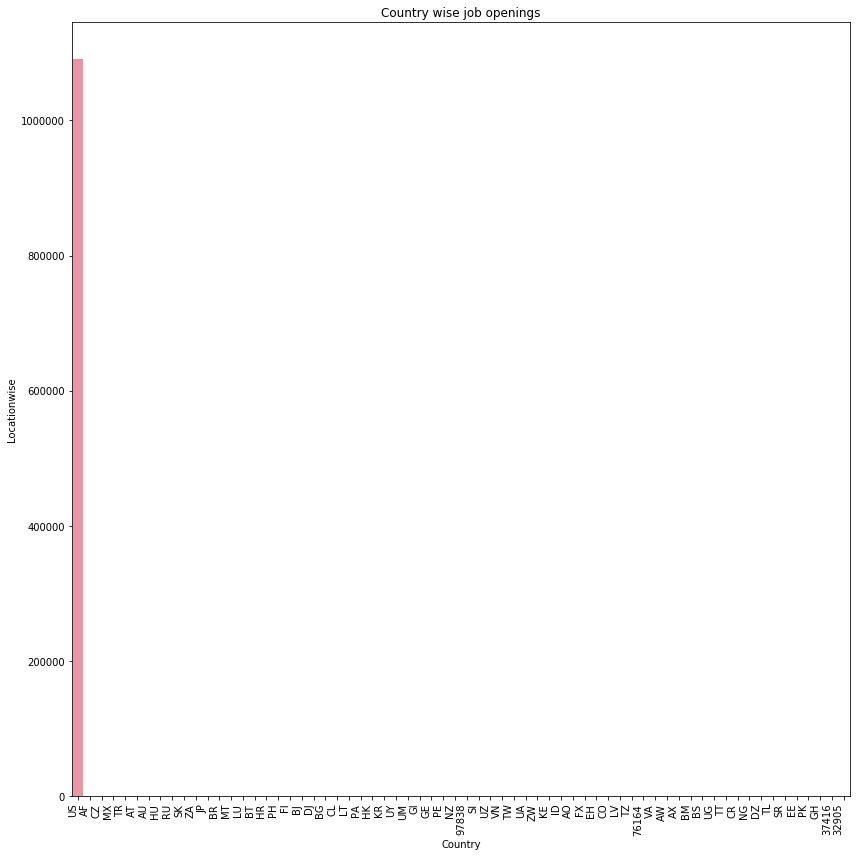

In [87]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

**PreProcessing**

In [0]:
jobs_US = jobs.loc[jobs['Country']=='US']

In [89]:
jobs_US[['City','State','Country']]

,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US
...,...,...,...
1091918,Amsterdam,NY,US
1091919,Birmingham,AL,US
1091920,Carthage,MS,US
1091921,Warren,MI,US


In [90]:
jobs_US.groupby(['City','State','Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False).head()

,City,State,Country,Locationwise
6601,Houston,TX,US,19306
9835,New York,NY,US,18395
2651,Chicago,IL,US,17806
3475,Dallas,TX,US,13139
610,Atlanta,GA,US,12352


In [0]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

In [92]:
State_wise_job_US

,State,Locationwise
5,CA,109630
48,TX,98071
10,FL,71024
16,IL,58743
38,NY,53998
42,PA,48999
39,OH,45048
34,NJ,35175
30,NC,34553
11,GA,33453


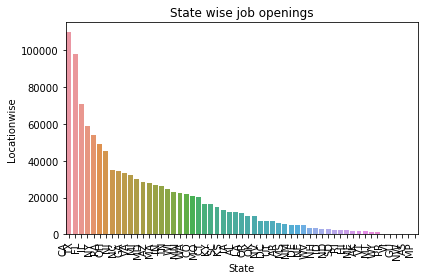

In [93]:
ax = sns.barplot(x="State", y="Locationwise",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

In [94]:
jobs_US.groupby(['City']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
2293,Cuchillo,1
7652,Picabo,1
2290,Crystola,1
2286,Crystal Hill,1


In [0]:
City_wise_location = jobs_US.groupby(['City']).size().reset_index(
    name='Locationwise').sort_values('Locationwise',ascending=False)

In [0]:
City_wise_location_th = City_wise_location.loc[City_wise_location['Locationwise']>=12]

In [98]:
City_wise_location_th

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
6838,Newport Coast,12
4655,Ijamsville,12
2510,Denmark,12
9904,University Heights,12


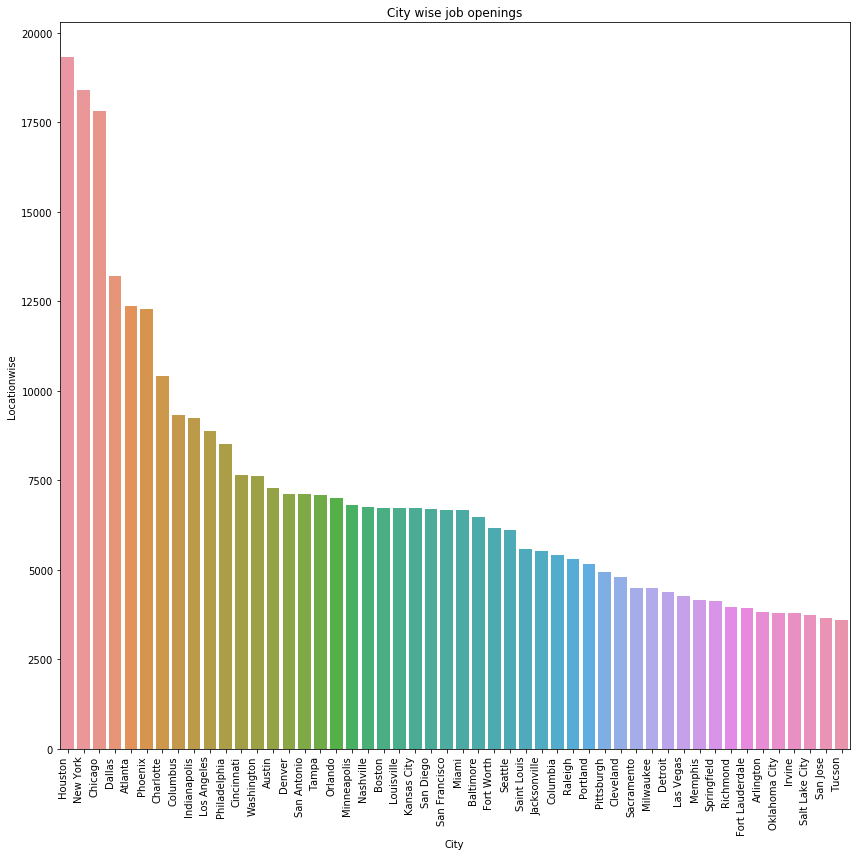

In [99]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise",data=City_wise_location_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

In [100]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False).head()

,Country,Locationwise
105,US,365740
47,IN,236
18,CA,108
81,PH,59
82,PK,59


In [0]:
user_training_US = users_training.loc[users_training['Country']=='US']

In [102]:
user_training_US.shape

(365740, 15)

In [103]:
user_training_US.groupby(['State']).size().reset_index(name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

,State,Locationwise_state
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299
41,PA,16206
12,GA,15003
34,NJ,14887
38,OH,14750
30,NC,13887


In [0]:
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

In [0]:
user_training_US_th = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=12]

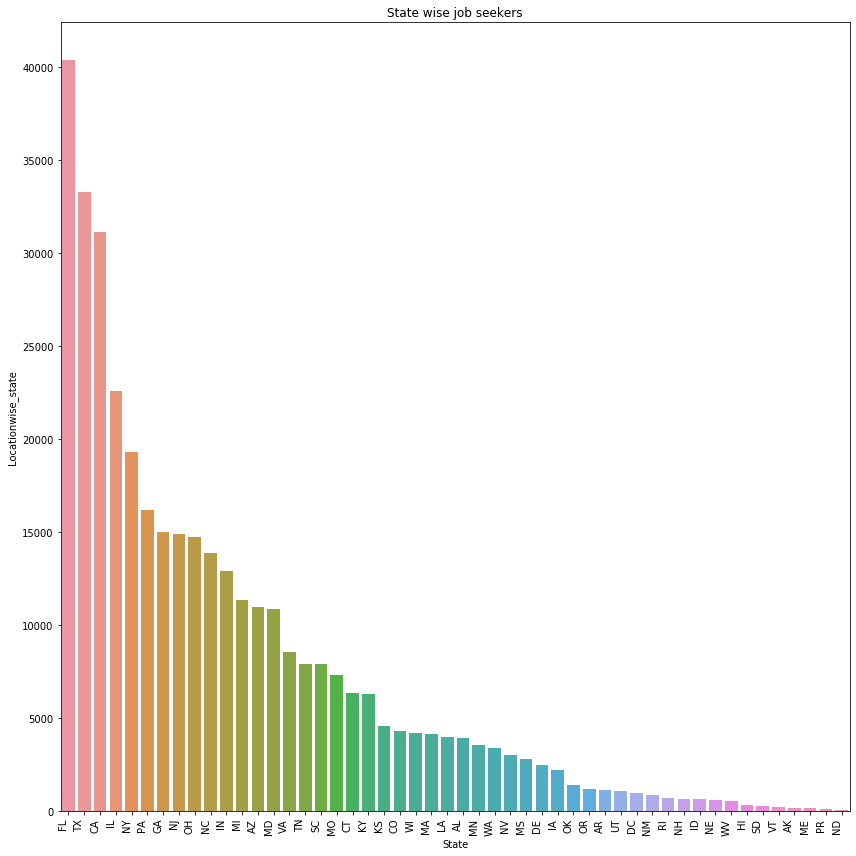

In [114]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

In [116]:
user_training_US.groupby(['City']).size().reset_index(name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

,City,Locationwise_city
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347
...,...,...
3046,Fort Pierre,1
3042,Fort Ogden,1
7369,Rancho Murieta,1
3032,Fort McCoy,1


In [0]:
user_training_US_city_wise = user_training_US.groupby(['City']).size().reset_index(name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

In [0]:
user_training_US_City_th = user_training_US_city_wise.loc[user_training_US_city_wise['Locationwise_city']>=12]

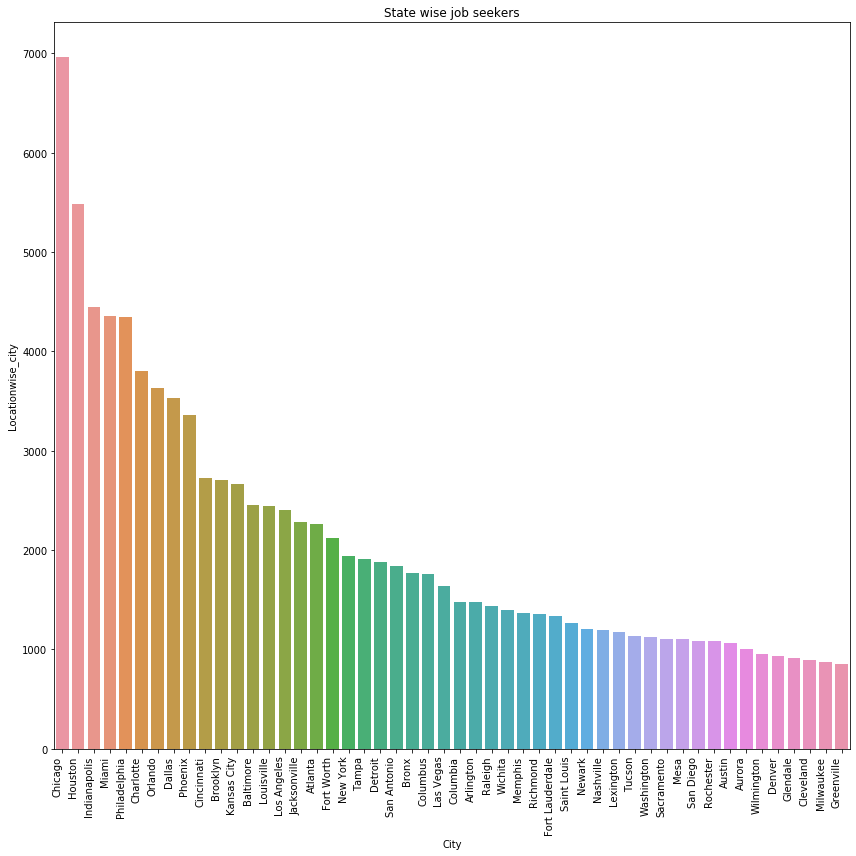

In [120]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise_city",data=user_training_US_City_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

**Model Tryout**

In [122]:
jobs_US.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [123]:
jobs_US.head().transpose()

,0,1,2,3,4
JobID,1,4,7,8,9
WindowID,1,1,1,1,1
Title,Security Engineer/Technical Lead,SAP Business Analyst / WM,P/T HUMAN RESOURCES ASSISTANT,Route Delivery Drivers,Housekeeping
Description,<p>Security Clearance Required:&nbsp; Top Secr...,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,CITY BEVERAGES Come to work for the best in th...,I make sure every part of their day is magica...
Requirements,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...
City,Washington,Charlotte,Winter Park,Orlando,Orlando
State,DC,NC,FL,FL,FL
Country,US,US,US,US,US
Zip5,20531,28217,32792,NaN,NaN
StartDate,2012-03-07 13:17:01.643,2012-03-21 02:03:44.137,2012-03-02 16:36:55.447,2012-03-03 09:01:10.077,2012-03-03 09:01:11.88


In [0]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]

In [125]:
jobs_US_base_line.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US


In [0]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

In [0]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [128]:
tfidf_matrix.shape

(10000, 515343)

In [0]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [130]:
cosine_sim[0]

array([1.        , 0.04300443, 0.00643851, ..., 0.03807697, 0.03807697,
       0.03807697])

In [0]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])

In [0]:
def get_recommendations(title):
    idx = indices[title]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]

In [133]:
get_recommendations('SAP Business Analyst / WM').head(10)

1                           SAP Business Analyst / WM
6051                    SAP FI/CO Business Consultant
5868                       SAP FI/CO Business Analyst
5159                          SAP Basis Administrator
5351    SAP Sales and Distribution Solution Architect
4796       Senior Specialist - SAP Configuration - SD
5117                       SAP Integration Specialist
5409            Senior Business Systems Analyst - SAP
5244                                 Business Analyst
4728           SAP ABAP Developer with PRA experience
Name: Title, dtype: object

In [134]:
get_recommendations('Security Engineer/Technical Lead').head(10)

0              Security Engineer/Technical Lead
5906                   Senior Security Engineer
3771                     Director of Admissions
6293    3 Network Architects needed - immediate
3557                          Assistant Manager
401          National Sales & Marketing Manager
2606               Inventory Analyst/ Scheduler
3757                        CLINICAL PHARMACIST
3478           Customer Service Representatives
3558                              Store Manager
Name: Title, dtype: object

In [135]:
get_recommendations('Immediate Opening').head(10)

13                           Immediate Opening
216                      Accounting/Bookkeeper
2872    Cable TV/Internet/Telephone Installers
8423                                    no job
4028                              Electricians
4029                              Electricians
4030                              Electricians
620                                     DENTAL
93                 A/C HEATING REFRIG MECHANIC
125                                   Optician
Name: Title, dtype: object

In [136]:
get_recommendations('EXPERIENCED ROOFERS').head(10)

26                                    EXPERIENCED ROOFERS
7949    Commercial Roofers  EXPERIENCED in  Hot Asphal...
51                                                 Driver
8012                                       OFFICE MANAGER
53                                                DRIVERS
33                         CNA OPENINGS AT TUSKAWILLA SNF
44                                   SALES REPRESENTATIVE
30                               Automotive Retail Dealer
60                                     Associate Attorney
59                                        SECURITY GUARDS
Name: Title, dtype: object